# Main Function Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

TORCH_SHOW_CPP_STACKTRACES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
from torch import _logging as logging

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path

In [106]:
datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')
logging_dir = None
if logging_dir is None:
    runs_dir = Path("./") / Path(f"rnn_runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

# MLBF For Realzies

In [125]:
torch.autograd.set_detect_anomaly(False)
#torch._logging.set_logs(dynamo = logging.INFO)

class MLBF(nn.Module):
    def __init__(self,
                users,
                antennas,
                depth=1,
                hidden_layers=200,
                outer_iterations=500,
                inner_iterations=10,
                update_rate=5 
                ):
        super(MLBF, self).__init__()

        # Performance Variables
        self.M = antennas
        self.N = users
        self.sigma = 1e-6
        self.mu = 1e-6
        self.P = 10
        self.w_ts = 1

        # Iteration related variables
        self.K = inner_iterations #Max inner loops for V
        self.I = inner_iterations #Max inner loops for u
        self.J = inner_iterations #Max inner loops for w
        self.T = outer_iterations #Max outer loops for each sub-problem
        self.tup = update_rate    #Update interval for LSTMs outer loop
        self.S = int(self.T / self.tup) #Maximum number of updates

        # Problem/solution tensors
        # H is the channel matrix. This will be randomly generated
        self.H = torch.randn((users, antennas), dtype=torch.complex64) / (users*antennas)
    
        # V is beamsteering matrix. 
            # Each row a user. Each column a transmit antenna
        self.V = torch.randn((users, antennas), dtype=torch.complex64)
        self.V = self.V / torch.linalg.norm(self.V) * torch.sqrt(torch.tensor(self.P))/100
    
        # Optimized/Learned importance for each user
        self.w = torch.randn((users, 1), dtype=torch.complex64)/users
    
        # Receiver gain for each user
        self.u = torch.randn((users, 1), dtype=torch.complex64)/users
        
        # System design user priorities
        self.Alpha = torch.ones((users, 1), dtype=torch.complex64)/users
        
        # System design user priorities
        self.e = torch.zeros((users, 1), dtype=torch.complex64)

        # Neural Networks for solving optimization problem
        # Network for updating the optimized user weights
        self.w_net = nn.LSTM(input_size = users, 
                                           hidden_size = users, 
                                           num_layers=hidden_layers, 
                                           bias=True, 
                                           batch_first=False, 
                                           dropout=0.0, 
                                           bidirectional=False, 
                                           proj_size=0, 
                                           device=None, 
                                           dtype=torch.complex64)
        #self.w_norm = F.normalize(input = users)
        # Network for updating the receiver gains
        self.u_net = nn.LSTM(input_size = users, 
                                           hidden_size = users, 
                                           num_layers=hidden_layers, 
                                           bias=True, 
                                           batch_first=False, 
                                           dropout=0.0, 
                                           bidirectional=False, 
                                           proj_size=0, 
                                           device=None, 
                                           dtype=torch.complex64)
        #self.u_norm = F.normalize(input = users)
        # Network for updating the V beamforming matrix
        self.V_net = nn.LSTM(input_size = users * antennas, # Input is one parameter for each user to receive from an antenna
                                           hidden_size = users * antennas, #users * antennas, 
                                           num_layers=hidden_layers,
                                           bias=True, 
                                           batch_first=False, 
                                           dropout=0.0, 
                                           bidirectional=False, 
                                           proj_size=0, 
                                           device=None, 
                                           dtype=torch.complex64)
        #self.V_norm = F.normalize(input = users * antennas)
        #Configure optimizer for this network
        
        self.optim = optim.Adam(self.parameters(), lr = 1e-4)
        
    #----------------------------- Calculate MSE -----------------------------
    def calc_MSE(self):
        # Calculate MSE (e vector) according to (5) in [5]
        for w, u, v, h, i in zip(self.w, 
                                 self.u, 
                                 self.V.t(), 
                                 self.H.t(), 
                                 range(self.N)):
            # Error contribution of how well beam points at current user + noise
            self.e[i] = torch.pow(u*torch.sqrt(torch.vdot(h.t(), v)) - 1, 2) + u*self.sigma

            # Error contribution of pointing at other users
            # Equation 5 from [5]
            for v_j, j in zip(self.V.t(),
                              range(self.N)):
                if(j != i):
                    self.e[i] = self.e[i] + (torch.abs(u)**2)*torch.vdot(h.t(),v_j)
    #----------------------------- Calculate Global Loss -----------------------------        
    def global_loss(self):
        # Calculate sum
        loss = torch.tensor(0.0)
        #Sum operation for (9) in [5]
        for w, alpha, e, i in zip(
                                 self.w, 
                                 self.Alpha, 
                                 self.e, 
                                 range(self.N)
                                ):
            loss = loss + alpha*( w*e - torch.log2(w))
            
        #Final Loss operation for (9) in [5]
        return loss + self.mu*torch.trace(self.V@(self.V.t().conj())) - self.mu*self.P
        
    #----------------------------- Calculate full sum -----------------------------
    def calc_full_sum(self):

        #Calculate the sum vector
        sum_total = torch.zeros(self.N, dtype=torch.complex64)
        
        #Outer Loop
        for h, i in zip( self.H.t(), 
                         range(self.N)):
            #Inner Loop
            for v, j in zip(self.V.t(),
                            range(self.N)
                            ):
                
                #Track the sum of every squared product
                sum_total[i] = sum_total[i] + torch.vdot(h, v)
        return sum_total

    #----------------------------- Calculate du -----------------------------
    def calc_u_grad(self):
        u_f = self.u.detach().clone()
        #u_f.requires_grad_()
        #print(u_f.shape)
        sum_total = self.calc_full_sum()

        for v, h, i in zip(
                        self.V.t(),
                        self.H.t(), 
                        range(self.N)):
        
            # using EQ 7. from [5]
            u_f[i,0] = torch.vdot(h, v) / (sum_total[i] + self.sigma)
            
        #return u_f.backward(retain_graph=True).grad
        return u_f - self.u

    #----------------------------- Calculate dw -----------------------------
    def calc_w_grad(self):
        #using EQ 6. from [5]
        
        w_f = torch.zeros((self.N,1), dtype=torch.complex64)
        sum_total = self.calc_full_sum()

        for v, h, i in zip(
                        self.V.t(),
                        self.H.t(), 
                        range(self.N)
                        ):
            # using EQ 6. from [5]
            w_f[i] =  (sum_total[i] + self.sigma) / (sum_total[i] - torch.vdot(h, v) + self.sigma)
        
        return w_f - self.w

    #----------------------------- Calculate dV -----------------------------
    def calc_V_grad(self):
        grad_V = torch.zeros((self.N , self.M), dtype=torch.complex64)
        
        A = torch.zeros((self.N, self.N), dtype=torch.complex64)

        #This is the PGD cost function from [12] to circumvent the matrix inversion
        #Calculate A using EQ 8. from [12]
        for w, u, h, alpha, i in zip(
                                     self.w, 
                                     self.u,
                                     self.H.t(),
                                     self.Alpha,
                                     range(self.N)
                                    ):
            A = A + alpha*w*(torch.abs(u)**2)*h.t().conj()@h
        # Cost function for V according to [12] 
        for v, w, u, h, alpha, i in zip(
                                     self.V.t(),
                                     self.w, 
                                     self.u,
                                     self.H.t(),
                                     self.Alpha,
                                     range(self.N)
                                    ):
            grad_V[:,i] = 2*A@v - 2*alpha*w*u*h
        #print(grad_V)wi
        return grad_V
            
    #Cap V to a maximum
    def Restrict_V(self, V):
        if(torch.abs(torch.trace(V@V.conj().t())) <= self.P):
            print("Plain V")
            return V
        else:
            print("Restricted V")
            return V / torch.linalg.norm(V) * torch.sqrt(torch.tensor(self.P))
        
    def run(self, Channel):
        # PyTorch order of operations:
        # [X] zero grad
        # [X] run model
            # [X] calc grad_f(u)
            # [X] run u_net to update u
            # [X] calc grad_f(w)
            # [X] run w_net to update w        will use LSTM with projections of corresponding size. Default: 0
            # [X] calc grad_f(V)
            # [X] run V_net to update V
            # [X] Restrict V to P
        # [X] loss = calculate criterion
        # [X] loss.backwards
        # [X] optimizer.step

        # zero grad
        #Initialize LSTM states
        u_C = None
        w_C = None
        V_C = None

        #Create the loss variable
        loss = torch.tensor(0.0)
        self.optim.zero_grad()
        for t in range(self.T):
            print(f"Begin Outer loop: {t}")
            
            # Run u_net
            for i in range(self.I):
                #Compute gradient of f(u)        will use LSTM with projections of corresponding size. Default: 0
                u_grad = self.calc_u_grad()
                writer.add_scalar('u_grad / Loops', torch.linalg.norm(u_grad).item(), t*self.tup + i)
                u_H, u_C = self.u_net(u_grad.t(), u_C)
                #print("u: " + str(self.u.shape))
                #print("uH: " + str(u_H.shape))
                writer.add_scalar('u_H / Loops', torch.linalg.norm(u_H).item(), t*self.tup + i)
                self.u = self.u + u_H.t()
                writer.add_scalars('abs(u_user)/Loops', 
                                   {f"u_{l}":u.item() for l, u in enumerate(self.u.abs())}, 
                                   t*self.tup + i)
                writer.add_scalars('re(u_H)/Loops', 
                                   {f"re(u)_{l}":u.item() for l, u in enumerate(u_H.real.t())}, 
                                   t*self.tup + i)
                writer.add_scalars('im(u_H)/Loops', 
                                   {f"im(u)_{l}":u.item() for l, u in enumerate(u_H.imag.t())}, 
                                   t*self.tup + i)
                
            # Run w_net
            for j in range(self.J):
                #Compute gradient of f(w)
                w_grad = self.calc_w_grad()
                writer.add_scalar('w_grad / Loops', torch.linalg.norm(w_grad).item(), t*self.tup + j)
                w_H, w_C = self.w_net(w_grad.t(), w_C)
                writer.add_scalar('w_H / Loops', torch.linalg.norm(w_H).item(), t*self.tup + j)
                #print("wH: " + str(w_H.shape))
                self.w = self.w + w_H.t()
                writer.add_scalars('abs(w_user)/Loops', 
                                   {f"w_{l}":w.item() for l, w in enumerate(self.w.abs())}, 
                                   t*self.tup + j)
                #print(w_H.shape)
                writer.add_scalars('re(w_H)/Loops', 
                                   {f"re(w)_{l}":w.item() for l, w in enumerate(w_H.real.t())}, 
                                   t*self.tup + j)
                writer.add_scalars('im(w_H)/Loops', 
                                   {f"im(w)_{l}":w.item() for l, w in enumerate(w_H.imag.t())}, 
                                   t*self.tup + j)
            # Run V_net
            for k in range(self.K):
                #Compute gradient of f(V)
                V_grad = self.calc_V_grad().reshape(self.N*self.M,1)
                writer.add_scalar('V_grad / Loops', torch.linalg.norm(V_grad).item(), t*self.tup + k)

                V_H, V_C = self.V_net(V_grad.t(), V_C)
                writer.add_scalar('V_H / Loops', torch.linalg.norm(V_H).item(), t*self.tup + k)
                
                dV = torch.reshape(V_H, (self.N, self.M))
                self.V = self.V + dV
                writer.add_scalar('dV_ant / Loops', torch.linalg.norm(dV).item(), t*self.tup + k)
                writer.add_scalars('mag(dV_antenna)/Loops', 
                                   {f"dv_{l}":torch.linalg.norm(v).item() for l, v in enumerate(dV.t().abs())}, 
                                   t*self.tup + k)
                
                self.V = self.Restrict_V(self.V)
                writer.add_scalars('mag(V_antenna)/Loops', 
                                   {f"v_{l}":torch.linalg.norm(v).item() for l, v in enumerate(self.V.t().abs())}, 
                                   t*self.tup + k)

            #Sum the loss weighted by w_ts
            self.calc_MSE()
            loss = loss.detach().clone() + self.w_ts*torch.abs(self.global_loss())/self.tup
            if(torch.isnan(loss)):
                print("Loss Diverged!")
                break
            
            # it's time to udpate the networks to the accumulated loss function
            if(t % self.tup == self.tup - 1):
                print(f"Backpropagating Loss {t}")
                # Backwards
                writer.add_scalar('Global Loss / Outer Loops', loss.item(), t)
                loss.backward(retain_graph=False)

                # Optimizer step
                self.optim.step()
                
                #Break-off old versions of V, w, e, and u to prepare for next pass
                self.V.detach_()
                self.w.detach_()
                self.u.detach_()
                self.e.detach_()

                #Reset hidden state variables for new batch of optimization
                V_C = None
                w_C = None
                u_C = None

                #Zero out the error
                self.e.zero_()
                loss.zero_()
                
                # zero grad --After we've updated the gradient we need to clear it to accumulate again
                self.optim.zero_grad()
                
            print(f"Completed Outer loop: {t}")

torch.manual_seed(1)
guy = MLBF( users = 4,
            antennas = 4,
            depth=1,
            hidden_layers=200,
            outer_iterations=20,
            inner_iterations=2,
            update_rate=5)

#Make a channel
channel = compute_channel(4, 4)

guy.H = channel

guy.run(channel)

#writer.close()

Begin Outer loop: 0
Plain V
Plain V
Completed Outer loop: 0
Begin Outer loop: 1
Plain V
Plain V
Completed Outer loop: 1
Begin Outer loop: 2
Plain V
Restricted V
Completed Outer loop: 2
Begin Outer loop: 3
Restricted V
Restricted V
Loss Diverged!


# Misunderstood MLBF Class function

In [126]:
class Other_Strangeness(nn.Module):
    def __init__(self, 
                 users, 
                 antennas, 
                 alpha = None):
        super(Other_Strangeness, self).__init__()
        
        # Basic features to track
        self.Antenna = antennas
        self.N = users

        # Meta Parameters:

        # Optimizers to be used by each RNN for V, u, and w

        # Network for updating the optimized user weights
        self.w_net = nn.Sequential(nn.LSTM(input_size = users, 
                                           hidden_size = 1, 
                                           num_layers=1, 
                                           bias=True, 
                                           batch_first=False, 
                                           dropout=0.0, 
                                           bidirectional=False, 
                                           proj_size=0, 
                                           device=None, 
                                           dtype=torch.complex64)
                                  )

        # Network for updating the receiver gains
        self.u_net = nn.Sequential(nn.LSTM(input_size = users, 
                                           hidden_size = 1, 
                                           num_layers=1, 
                                           bias=True, 
                                           batch_first=False, 
                                           dropout=0.0, 
                                           bidirectional=False, 
                                           proj_size=0, 
                                           device=None, 
                                           dtype=torch.complex64)
                                  )
        
        # Network for updating the V beamforming matrix
        self.V_net = nn.Sequential(nn.LSTM(input_size = users * antennas, # Input is one parameter for each user to receive from an antenna
                                           hidden_size = 1, 
                                           num_layers=1, 
                                           bias=True, 
                                           batch_first=False, 
                                           dropout=0.0, 
                                           bidirectional=False, 
                                           proj_size=0, 
                                           device=None, 
                                           dtype=torch.complex64)
                                  )
        
        # H is the channel matrix. This will be randomly generated
        self.H = torch.ones((users, antennas), dtype=torch.complex64) / (users*antennas)

        # V is beamsteering matrix. 
            # Each row a user. Each column a transmit antenna
        self.V = torch.ones((users, antennas), dtype=torch.complex64)

        # Optimized/Learned importance for each user
        self.w = torch.ones((users, 1), dtype=torch.complex64)

        # Receiver gain for each user
        self.u = torch.ones((users, 1), dtype=torch.complex64)

        # System designer can assign an importance to each user
        if alpha is None:
            self.Alpha = torch.ones((users,1), dtype=torch.complex64)/users
        else:
            self.Alpha = alpha

        # Mean-Square Error for each user:
        self.e = torch.ones((users, 1), dtype=torch.complex64)

        #This is actually sigma^2
        self.sigma = 0.1

        self.mu = 1
    
    def calc_MSE(self):
        for w, u, v, h, i in zip(self.w, 
                                 self.u, 
                                 self.V.t(), 
                                 self.H.t(), 
                                 range(self.N)):
            # Error contribution of how well beam points at current user + noise
            self.e[i] = torch.pow(u*torch.conj(h.transpose(-1,0))@v - 1,2) + u*self.sigma

            # Error contribution of pointing at other users
            for j in range(self.N):
                if(j != i):
                    self.e[i] = self.e[i] + torch.pow(u*torch.conj(h.transpose(-1,0))@v,2)
    
    def calc_update_w_u(self):
        #Outer Loop
        for h, i in zip( self.H.t(), 
                         range(self.N)):
            sum_total = 0
            sum_exclusive = 0
            
            #Inner Loop
            for v, j in zip(self.V.t(),
                            range(self.N)
                            ):

                #every loop, a product is used
                prod = torch.vdot(h, v)
                
                #Track the sum of every squared product 
                sum_total = sum_total + prod**2

                #Exclusive sum for where i != j
                if j != i:
                    sum_exclusive = sum_exclusive + prod**2

                #Set the numerator of u
                if j == i:
                    self.u[i] = prod

            #Update u_i, w_i
            # using EQ 7. from [5]
            self.u[i] = self.u[i] / (sum_total + self.sigma)
            #using EQ 6. from [5]
            self.w[i] = (sum_total + self.sigma) / (sum_exclusive + self.sigma)
                
    def calc_update_v(self):
        A = 0#torch.zeros((self.N, self.N), dtype=self.H.dtype)
        #Calculate (A + uI)^-1 using EQ 8. from [5]
        for w, u, h, alpha, i in zip(
                                     self.w, 
                                     self.u,
                                     self.H.t(),
                                     self.Alpha,
                                     range(self.N)
                                    ):           
            A = A + alpha*w*(torch.abs(u)**2)*h.t().conj()@h
        A_prod = torch.linalg.inv(A + self.mu*torch.eye(self.N))

        #Calculate v_i
        for w, u, h, alpha, i in zip(
                                     self.w, 
                                     self.u,
                                     self.H.t(),
                                     self.Alpha,
                                     range(self.N)
                                    ):
            self.V[:,i] = alpha * u * w * (h @ A_prod)

    # Update w, u, V
    def calc_update(self):
        pass
        
model = Other_Strangeness(4,7)
model.calc_MSE()
model.calc_update_w_u()
model.calc_update_v()

In [62]:
x = torch.randn(4,7)
y = torch.ones((4,4))
x

tensor([[ 1.5598,  1.6137,  0.9035, -0.3313, -0.6225,  0.8683,  1.5788],
        [-0.2687, -0.7519, -0.1923, -0.2689,  0.6816,  1.2936, -1.0451],
        [ 0.1007,  0.1129,  0.9491, -0.9735, -0.2605, -1.6384, -0.5019],
        [ 1.2305, -0.4356,  0.4193,  1.9965, -0.3644, -2.4067, -0.6000]])

In [63]:
x.t()

tensor([[ 1.5598, -0.2687,  0.1007,  1.2305],
        [ 1.6137, -0.7519,  0.1129, -0.4356],
        [ 0.9035, -0.1923,  0.9491,  0.4193],
        [-0.3313, -0.2689, -0.9735,  1.9965],
        [-0.6225,  0.6816, -0.2605, -0.3644],
        [ 0.8683,  1.2936, -1.6384, -2.4067],
        [ 1.5788, -1.0451, -0.5019, -0.6000]])

# Compute the Channel

In [2]:
def compute_channel(users, 
                    antennas):
    
    #Create the complex channel realization
    #channel_mat = (np.random.rand(users, antennas) + 1j*np.random.rand(users, antennas))/np.sqrt(2)
    channel_mat = torch.rand((users, antennas), dtype=torch.complex64)
    
    return channel_mat

# Compute the WMMSE Unfolded Algorithm Solution

In [128]:
#Libraries for WMMSE Algorithm
import copy
from copy import deepcopy
import time

Utility functions for running the main WMMSE function from \[5\]

In [123]:
def compute_weighted_sum_rate(user_weights, channel, precoder, noise_power, selected_users):
   result = 0
   nr_of_users = np.size(channel,0)
   
   for user_index in range(nr_of_users):
     if user_index in selected_users:
       user_sinr = compute_sinr(channel, precoder, noise_power, user_index, selected_users)
       result = result + user_weights[user_index]*np.log2(1 + user_sinr)
    
   return result

def compute_P(Phi_diag_elements, Sigma_diag_elements, mu):
  nr_of_BS_antennas = Phi_diag_elements.size
  mu_array = mu*np.ones(Phi_diag_elements.size)
  result = np.divide(Phi_diag_elements,(Sigma_diag_elements + mu_array)**2)
  result = np.sum(result)
  return result


def compute_norm_of_complex_array(x):
  result = np.sqrt(np.sum((np.absolute(x))**2))
  return result


def compute_sinr(channel, precoder, noise_power, user_id, selected_users):
    nr_of_users = np.size(channel,0)
    numerator = (np.absolute(np.matmul(np.conj(channel[user_id,:]),precoder[user_id,:])))**2

    inter_user_interference = 0
    for user_index in range(nr_of_users):
      if user_index != user_id and user_index in selected_users:
        inter_user_interference = inter_user_interference + (np.absolute(np.matmul(np.conj(channel[user_id,:]),precoder[user_index,:])))**2
    denominator = noise_power + inter_user_interference

    result = numerator/denominator
    return result


def compute_user_weights(nr_of_users, selected_users):
  result = np.ones(nr_of_users)
  for user_index in range(nr_of_users):
    if not (user_index in selected_users):
      result[user_index] = 0
  return result

Function for iteratively solving the WMMSE optimization problem according to \[5\]

In [121]:
def run_WMMSE(epsilon, channel, selected_users, total_power, noise_power, user_weights, max_nr_of_iterations, log = False):

  nr_of_users = np.size(channel,0)
  nr_of_BS_antennas = np.size(channel,1)
  WSR=[] # to check if the WSR (our cost function) increases at each iteration of the WMMSE
  break_condition = epsilon + 1 # break condition to stop the WMMSE iterations and exit the while
  receiver_precoder = np.zeros(nr_of_users) + 1j*np.zeros(nr_of_users) # receiver_precoder is "u" in the paper of Shi et al. (it's a an array of complex scalars)
  mse_weights = np.ones(nr_of_users) # mse_weights is "w" in the paper of Shi et al. (it's a an array of real scalars)
  transmitter_precoder = np.zeros((nr_of_users, nr_of_BS_antennas)) + 1j*np.zeros((nr_of_users, nr_of_BS_antennas))# transmitter_precoder is "v" in the paper of Shi et al. (it's a complex matrix)
  
  new_receiver_precoder = np.zeros(nr_of_users) + 1j*np.zeros(nr_of_users) # for the first iteration 
  new_mse_weights = np.zeros(nr_of_users) # for the first iteration
  new_transmitter_precoder = np.zeros((nr_of_users, nr_of_BS_antennas)) + 1j*np.zeros((nr_of_users, nr_of_BS_antennas)) # for the first iteration

  
  # Initialization of transmitter precoder
  for user_index in range(nr_of_users):
    if user_index in selected_users:
      transmitter_precoder[user_index,:] = channel[user_index,:]
  transmitter_precoder = transmitter_precoder/np.linalg.norm(transmitter_precoder)*np.sqrt(total_power)
  
  # Store the WSR obtained with the initialized trasmitter precoder    
  WSR.append(compute_weighted_sum_rate(user_weights, channel, transmitter_precoder, noise_power, selected_users))

  # Compute the initial power of the transmitter precoder
  initial_power = 0
  for user_index in range(nr_of_users):
    if user_index in selected_users:
      initial_power = initial_power + (compute_norm_of_complex_array(transmitter_precoder[user_index,:]))**2 
  if log == True:
    print("Power of the initialized transmitter precoder:", initial_power)

  nr_of_iteration_counter = 0 # to keep track of the number of iteration of the WMMSE

  while break_condition >= epsilon and nr_of_iteration_counter<=max_nr_of_iterations:
    
    nr_of_iteration_counter = nr_of_iteration_counter + 1
    if log == True:
      print("WMMSE ITERATION: ", nr_of_iteration_counter)

    # Optimize receiver precoder - eq. (5) in the paper of Shi et al.
    for user_index_1 in range(nr_of_users):
      if user_index_1 in selected_users:
        user_interference = 0.0
        for user_index_2 in range(nr_of_users):
          if user_index_2 in selected_users:
            user_interference = user_interference + (np.absolute(np.matmul(np.conj(channel[user_index_1,:]),transmitter_precoder[user_index_2,:])))**2

        new_receiver_precoder[user_index_1] = np.matmul(np.conj(channel[user_index_1,:]),transmitter_precoder[user_index_1,:]) / (noise_power + user_interference)

    # Optimize mse_weights - eq. (13) in the paper of Shi et al.
    for user_index_1 in range(nr_of_users):
      if user_index_1 in selected_users:

        user_interference = 0 # it includes the channel of all selected users
        inter_user_interference = 0 # it includes the channel of all selected users apart from the current one
        
        for user_index_2 in range(nr_of_users):
          if user_index_2 in selected_users:
            user_interference = user_interference + (np.absolute(np.matmul(np.conj(channel[user_index_1,:]),transmitter_precoder[user_index_2,:])))**2
        for user_index_2 in range(nr_of_users):
          if user_index_2 != user_index_1 and user_index_2 in selected_users:
            inter_user_interference = inter_user_interference + (np.absolute(np.matmul(np.conj(channel[user_index_1,:]),transmitter_precoder[user_index_2,:])))**2
        
        new_mse_weights[user_index_1] = (noise_power + user_interference)/(noise_power + inter_user_interference)

    A = np.zeros((nr_of_BS_antennas,nr_of_BS_antennas))+1j*np.zeros((nr_of_BS_antennas,nr_of_BS_antennas))
    for user_index in range(nr_of_users):
      if user_index in selected_users:
        # hh should be an hermitian matrix of size (nr_of_BS_antennas X nr_of_BS_antennas)
        hh = np.matmul(np.reshape(channel[user_index,:],(nr_of_BS_antennas,1)),np.conj(np.transpose(np.reshape(channel[user_index,:],(nr_of_BS_antennas,1)))))
        A = A + (new_mse_weights[user_index]*user_weights[user_index]*(np.absolute(new_receiver_precoder[user_index]))**2)*hh

    Sigma_diag_elements_true, U = np.linalg.eigh(A)
    Sigma_diag_elements = copy.deepcopy(np.real(Sigma_diag_elements_true))
    Lambda = np.zeros((nr_of_BS_antennas,nr_of_BS_antennas)) + 1j*np.zeros((nr_of_BS_antennas,nr_of_BS_antennas))
    
    for user_index in range(nr_of_users):
      if user_index in selected_users:     
        hh = np.matmul(np.reshape(channel[user_index,:],(nr_of_BS_antennas,1)),np.conj(np.transpose(np.reshape(channel[user_index,:],(nr_of_BS_antennas,1)))))
        Lambda = Lambda + ((user_weights[user_index])**2)*((new_mse_weights[user_index])**2)*((np.absolute(new_receiver_precoder[user_index]))**2)*hh

    Phi = np.matmul(np.matmul(np.conj(np.transpose(U)),Lambda),U)
    Phi_diag_elements_true = np.diag(Phi)
    Phi_diag_elements = copy.deepcopy(Phi_diag_elements_true)
    Phi_diag_elements = np.real(Phi_diag_elements)

    for i in range(len(Phi_diag_elements)):
      if Phi_diag_elements[i]<np.finfo(float).eps:
        Phi_diag_elements[i] = np.finfo(float).eps
      if (Sigma_diag_elements[i])<np.finfo(float).eps:
        Sigma_diag_elements[i] = 0

    # Check if mu = 0 is a solution (eq.s (15) and (16) of in the paper of Shi et al.)
    power = 0 # the power of transmitter precoder (i.e. sum of the squared norm)
    for user_index in range(nr_of_users):
      if user_index in selected_users:
        if np.linalg.det(A) != 0:
          w = np.matmul(np.linalg.inv(A),np.reshape(channel[user_index,:],(nr_of_BS_antennas,1)))*user_weights[user_index]*new_mse_weights[user_index]*(new_receiver_precoder[user_index])
          power = power + (compute_norm_of_complex_array(w))**2

    # If mu = 0 is a solution, then mu_star = 0
    if np.linalg.det(A) != 0 and power <= total_power:
      mu_star = 0
    # If mu = 0 is not a solution then we search for the "optimal" mu by bisection
    else:
      power_distance = [] # list to store the distance from total_power in the bisection algorithm 
      mu_low = np.sqrt(1/total_power*np.sum(Phi_diag_elements))
      mu_high = 0
      low_point = compute_P(Phi_diag_elements, Sigma_diag_elements, mu_low)
      high_point = compute_P(Phi_diag_elements, Sigma_diag_elements, mu_high)

      obtained_power = total_power + 2*power_tolerance # initialization of the obtained power such that we enter the while 

      # Bisection search
      while np.absolute(total_power - obtained_power) > power_tolerance:
        mu_new = (mu_high + mu_low)/2
        obtained_power = compute_P(Phi_diag_elements, Sigma_diag_elements, mu_new) # eq. (18) in the paper of Shi et al.
        power_distance.append(np.absolute(total_power - obtained_power))
        if obtained_power > total_power:
          mu_high = mu_new
        if obtained_power < total_power:
          mu_low = mu_new
      mu_star = mu_new
      if log == True:
        print("first value:", power_distance[0])
        plt.title("Distance from the target value in bisection (it should decrease)")
        plt.plot(power_distance)
        plt.show()

    for user_index in range(nr_of_users):
      if user_index in selected_users:
        new_transmitter_precoder[user_index,:] = np.matmul(np.linalg.inv(A + mu_star*np.eye(nr_of_BS_antennas)),channel[user_index,:])*user_weights[user_index]*new_mse_weights[user_index]*(new_receiver_precoder[user_index]) 

    # To select only the weights of the selected users to check the break condition
    mse_weights_selected_users = []
    new_mse_weights_selected_users = []
    for user_index in range(nr_of_users): 
      if user_index in selected_users:
        mse_weights_selected_users.append(mse_weights[user_index])
        new_mse_weights_selected_users.append(new_mse_weights[user_index])

    mse_weights = deepcopy(new_mse_weights)
    transmitter_precoder = deepcopy(new_transmitter_precoder)
    receiver_precoder = deepcopy(new_receiver_precoder)

    WSR.append(compute_weighted_sum_rate(user_weights, channel, transmitter_precoder, noise_power, selected_users))
    break_condition = np.absolute(np.log2(np.prod(new_mse_weights_selected_users))-np.log2(np.prod(mse_weights_selected_users)))

  if log == True:
    plt.title("Change of the WSR at each iteration of the WMMSE (it should increase)")
    plt.plot(WSR,'bo')
    plt.show()

  return transmitter_precoder, receiver_precoder, mse_weights, WSR[-1]


Power of the initialized transmitter precoder: 9.999999999999998
WMMSE ITERATION:  1
first value: 3.037403585138338


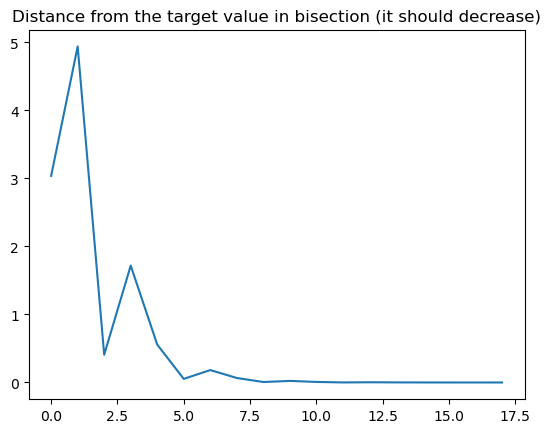

WMMSE ITERATION:  2
first value: 5.068261574316502


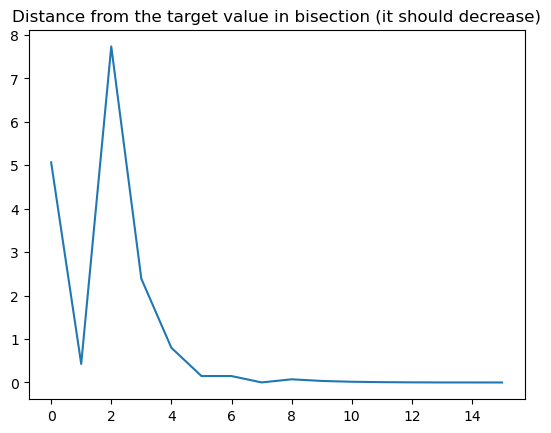

WMMSE ITERATION:  3
first value: 6.162027848196044


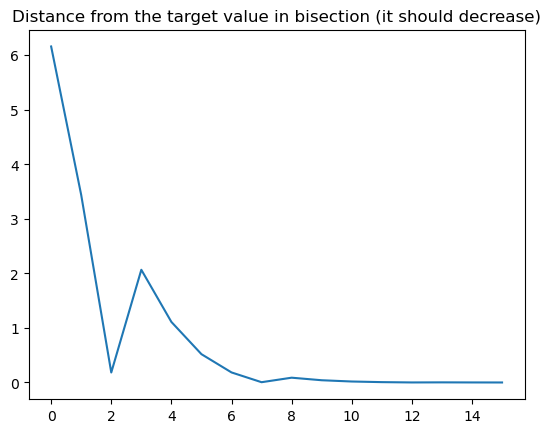

WMMSE ITERATION:  4
first value: 6.782111053125705


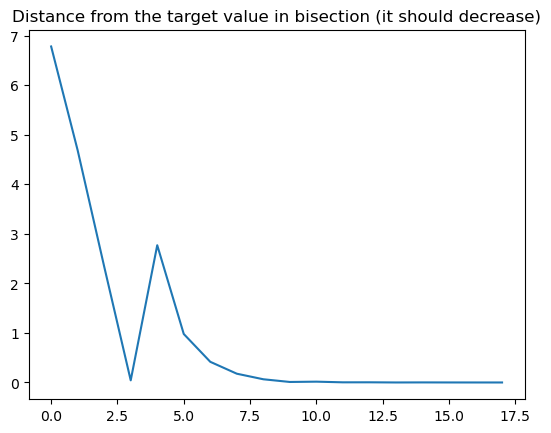

WMMSE ITERATION:  5
first value: 6.941260866304328


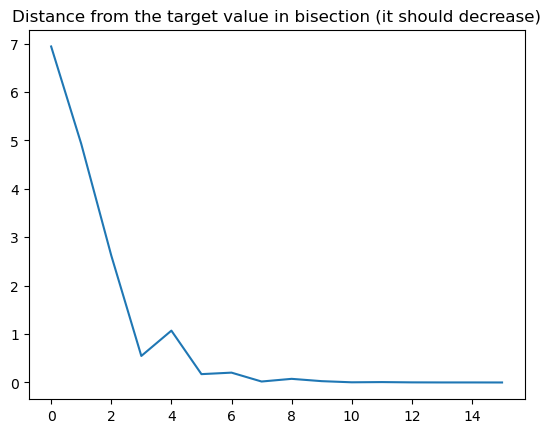

WMMSE ITERATION:  6
first value: 6.875152359770587


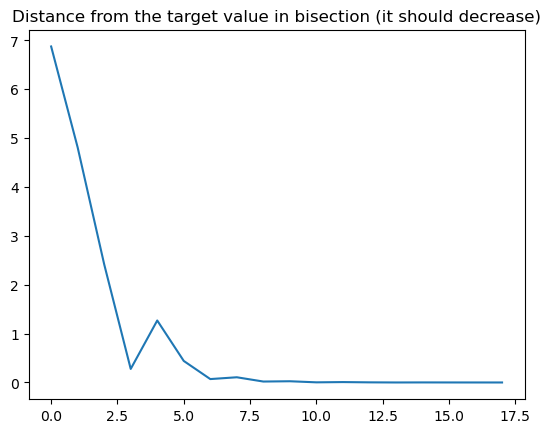

WMMSE ITERATION:  7
first value: 6.851742803090838


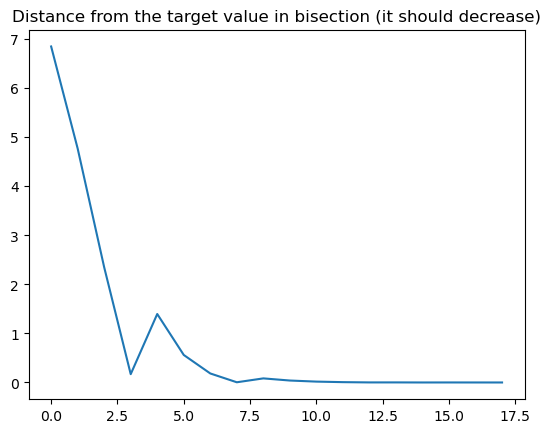

WMMSE ITERATION:  8
first value: 6.846936718461272


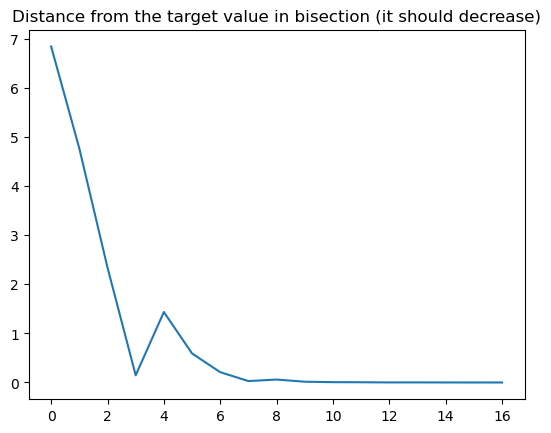

WMMSE ITERATION:  9
first value: 6.845797203299184


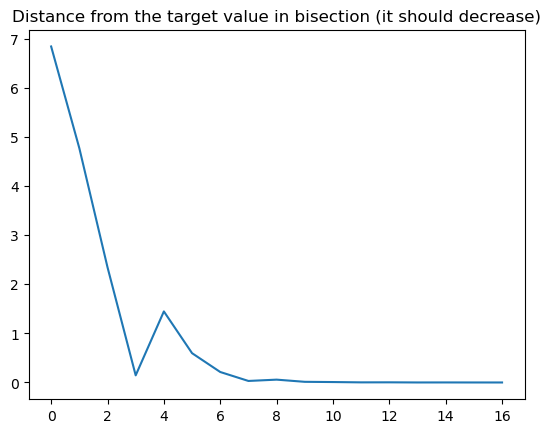

WMMSE ITERATION:  10
first value: 6.8451216831296335


/tmp/ipykernel_236838/1227354381.py:15: RuntimeWarning: divide by zero encountered in divide
  result = np.divide(Phi_diag_elements,(Sigma_diag_elements + mu_array)**2)


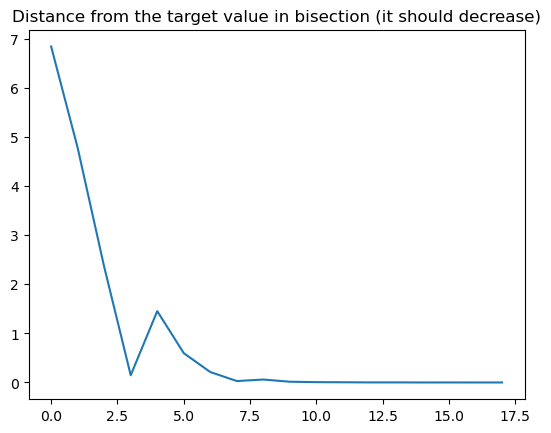

WMMSE ITERATION:  11
first value: 6.844440806219812


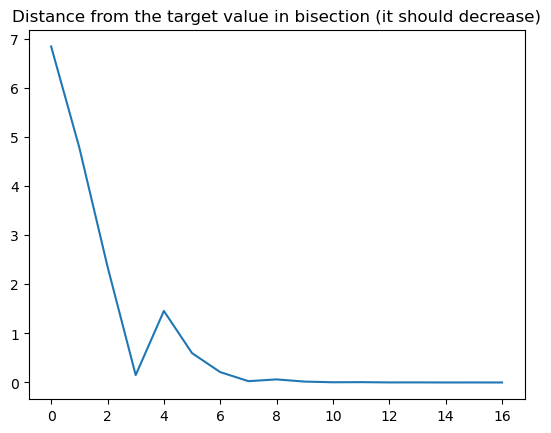

WMMSE ITERATION:  12
first value: 6.843715119992289


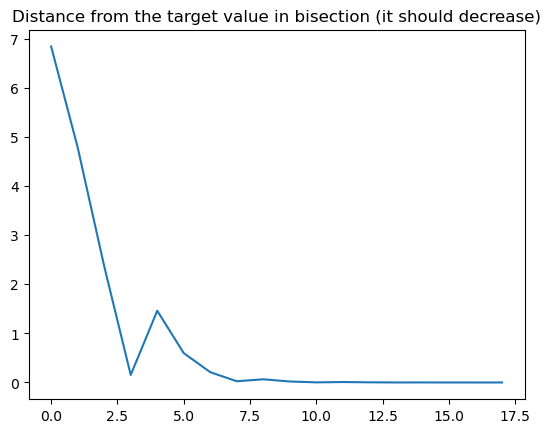

WMMSE ITERATION:  13
first value: 6.842929821846587


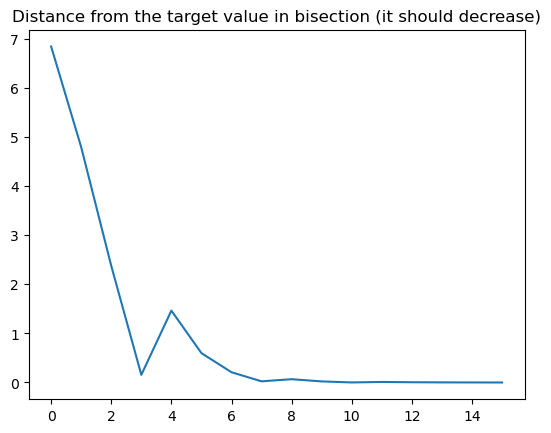

WMMSE ITERATION:  14
first value: 6.842170882263785


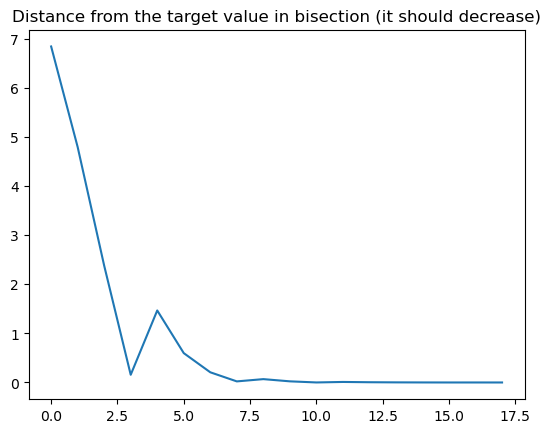

WMMSE ITERATION:  15
first value: 6.841455546917353


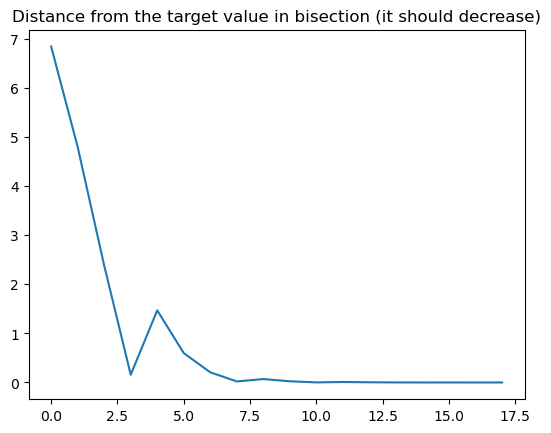

WMMSE ITERATION:  16
first value: 6.8407823165035015


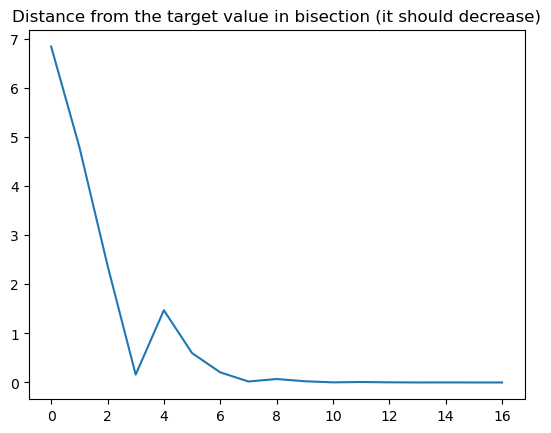

WMMSE ITERATION:  17
first value: 6.840156489087036


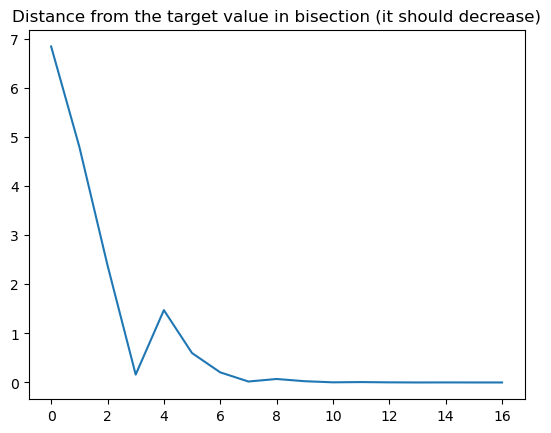

WMMSE ITERATION:  18
first value: 6.839584905928828


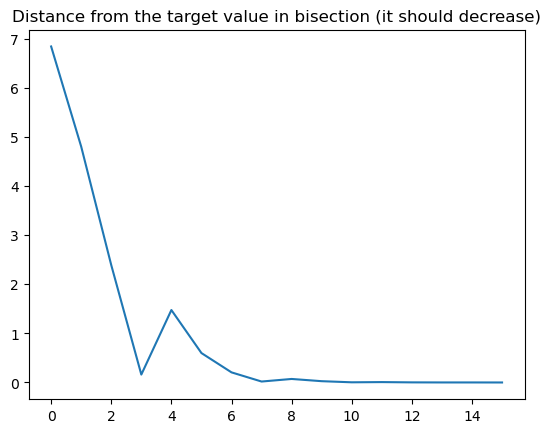

WMMSE ITERATION:  19
first value: 6.839097549928121


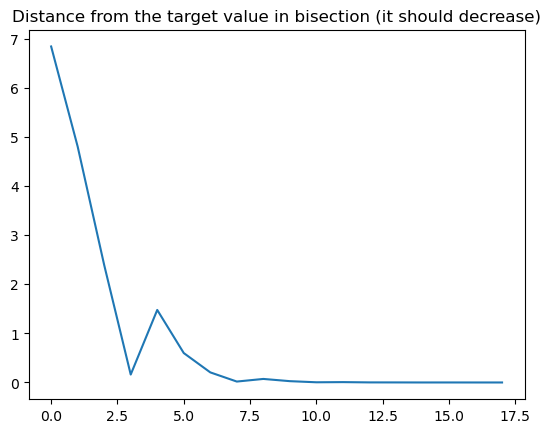

WMMSE ITERATION:  20
first value: 6.838645336552879


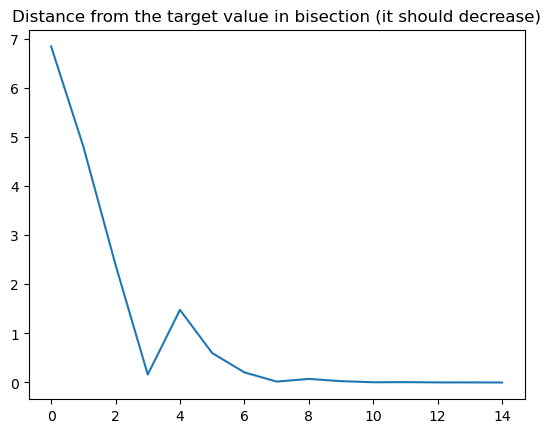

WMMSE ITERATION:  21
first value: 6.8382693405743735


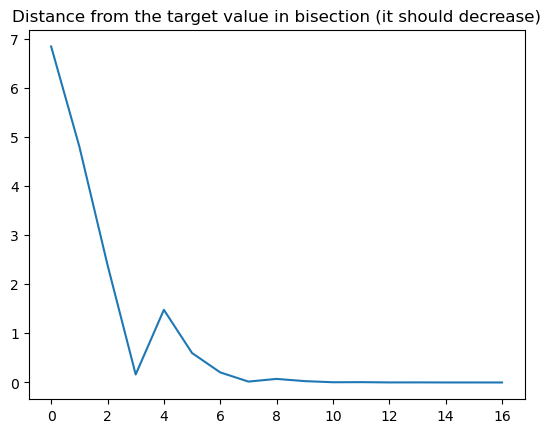

WMMSE ITERATION:  22
first value: 6.8379238718315065


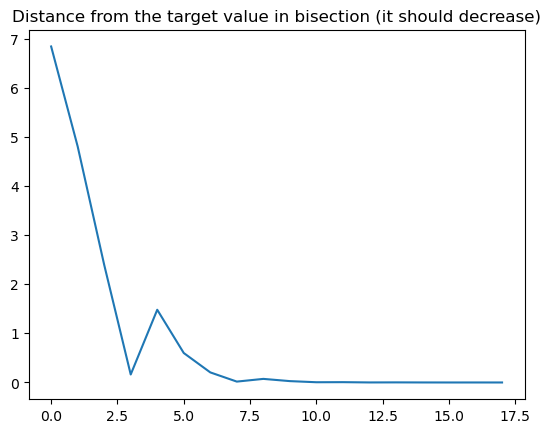

WMMSE ITERATION:  23
first value: 6.83762848619542


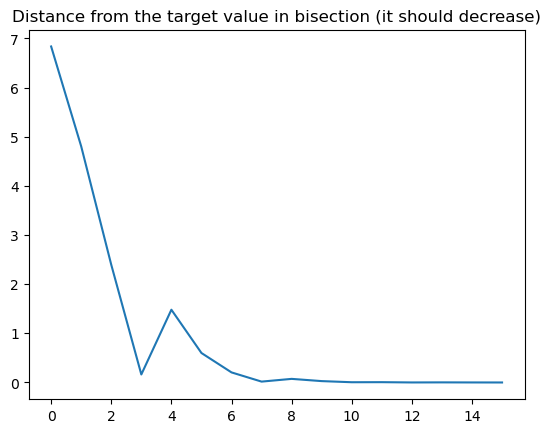

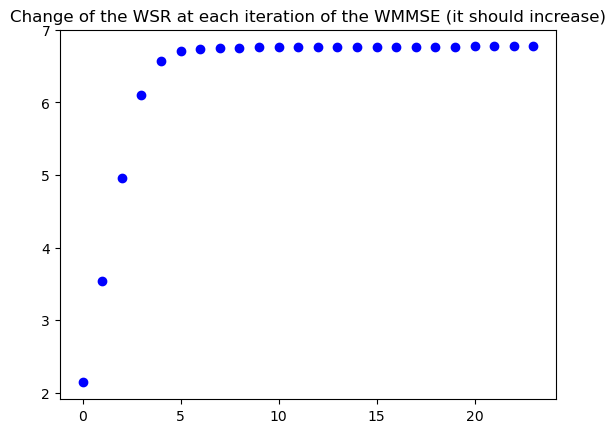

(array([[ 1.01357092e-01-1.83582128e-01j,  1.16271122e+00+9.52403770e-01j,
         -7.50933467e-01+8.33474378e-01j,  1.10812374e+00+6.00885576e-01j],
        [ 1.19292229e+00+3.83403160e-01j, -5.46825408e-01-3.87177264e-01j,
          1.52737446e+00-1.47907358e-01j, -5.49385049e-01+4.16863678e-01j],
        [-1.05543081e-12+2.58168929e-12j,  1.38803727e-11+1.27443094e-11j,
          8.12243066e-12-1.36133881e-12j, -1.15478710e-11-8.01520022e-12j],
        [ 3.03404841e-15-1.47114417e-14j,  1.00261439e-14+1.22843404e-14j,
          3.21637281e-15+7.99298641e-15j, -1.90522866e-14-4.59888921e-15j]]),
 array([2.30089997e-01+8.10502735e-16j, 3.55460791e-01+7.76528650e-16j,
        7.03675251e-12+1.13402678e-26j, 1.07161512e-14+1.85860378e-29j]),
 array([17.46594561,  6.250742  ,  1.        ,  1.        ]),
 array([6.77055905]))

In [129]:
users = 4
tx_antennas = 4
total_power = 10
scheduled_users = [0,1,2,3] 

#Bad Settings >:(
power_tolerance = 0.0001

user_weights = np.ones((users, 1))

channel = compute_channel(users = users, 
                          antennas = tx_antennas).numpy()

run_WMMSE(epsilon = 1e-4, 
          channel = channel, 
          selected_users = scheduled_users, 
          total_power = total_power, 
          noise_power = 1, 
          user_weights = user_weights, 
          max_nr_of_iterations = 100, 
          log = True)

# Works Cited


    [1] D. Sun, Y. Xi, A. Yaqot, H. Hellbrück, and H. Wu, “Throughput maximization using deep complex networks for industrial internet of things,” Sensors, vol. 23, no. 2, p. 951, Jan. 2023, doi:10.3390/s23020951.

    [2] O. Elijah, S. K. Abdul Rahim, W. K. New, C. Y. Leow, K. Cumanan, and T. Kim Geok, “Intelligent massive MIMO systems for beyond 5G networks: An overview and future trends,” IEEE Access, vol. 10, pp. 102532–102563, 2022, doi: 10.1109/ACCESS.2022.3208284.

    [3] L. Pellaco and J. Jaldén, “A matrix-inverse-free implementation of the MU-MIMO WMMSE beamforming algorithm,” IEEE Transactions on Signal Processing, vol. 70, pp. 6360–6375, 2022, doi:10.1109/TSP.2023.3238275.

    [4] H. A. Kassir, Z. D. Zaharis, P. I. Lazaridis, N. V. Kantartzis, T. V. Yioultsis, and T. D. Xenos, “A review of the state of the art and future challenges of deep learning-based beamforming,” IEEE Access, vol. 10, pp. 80869–80882, 2022, doi: 10.1109/ACCESS.2022.3195299.

    [5] J. Xia and D. Gunduz, “Meta-learning based beamforming design for MISO downlink,” in 2021 IEEE international symposium on information theory (ISIT), IEEE, Jul. 2021. doi:10.1109/isit45174.2021.9518251.

    [6] S. Lu, S. Zhao, and Q. Shi, “Learning-based massive beamforming.” 2020. Available: https://arxiv.org/abs/2009.09406

    [7] J. Hoydis, S. ten Brink, and M. Debbah, “Massive MIMO in the UL/DL of cellular networks: How many antennas do we need?” IEEE Journal on Selected Areas in Communications, vol. 31, no. 2, pp. 160–171, 2013, doi: 10.1109/JSAC.2013.130205.

    [8] J. Zhou and Y. Zhu, “The linear minimum mean-square error estimation with constraints and its applications,” in 2006 international conference on computational intelligence and security, 2006, pp. 1801–1804. doi: 10.1109/ICCIAS.2006.295373.

    [9] Q. Shi, M. Razaviyayn, Z.-Q. Luo, and C. He, “An iteratively weighted MMSE approach to distributed sum-utility maximization for a MIMO interfering broadcast channel,” IEEE Transactions on Signal Processing, vol. 59, no. 9, pp. 4331–4340, 2011, doi: 10.1109/TSP.2011.2147784.

    [10] M. Akrout, A. Feriani, F. Bellili, A. Mezghani, and E. Hossain, “Domain generalization in machine learning models for wireless communications: Concepts, state-of-the-art, and open issues,” IEEE Communications Surveys & Tutorials, pp. 1–1, 2023, doi: 10.1109/COMST.2023.3326399.

    [11] T. Maksymyuk, J. Gazda, O. Yaremko, and D. Nevinskiy, “Deep learning based massive MIMO beamforming for 5G mobile network,” in 2018 IEEE 4th international symposium on wireless systems within the international conferences on intelligent data acquisition and advanced computing systems (IDAACS-SWS), 2018, pp. 241–244. doi: 10.1109/IDAACS-SWS.2018.8525802.

    [12] R. Lovato and X. Gong, “Phased antenna array beamforming using convolutional neural networks,”in 2019 IEEE international symposium on antennas and propagation and USNC-URSI radio science meeting, 2019, pp. 1247–1248. doi: 10.1109/APUSNCURSINRSM.2019.8888573. -->